# Where is a hospital in Manhattan Downtown?

In this lab we will create 2 vector indices to answer a very simple question: if you are in Manhattan downtown, where is the nearest hospital? We will base our soultion on two sources of data:
- [Points of Interest dataset](https://drive.google.com/file/d/1LUudtCADqSxRl18ZzCzyPPGfhuUo2ZZs/view?usp=sharing). This is a 10% sample of a bigger dataset. Download and uncompress the file.
- [Google Geocoding API](https://developers.google.com/maps/documentation/geocoding/start) or any other [equivalent service](https://gisgeography.com/geocoders/). For Google you will need to obtain a key. **PLEASE DO NOT SUBMIT THE KEY TO MOODLE :)**

In [1]:
!pip3 install sklearn
!pip3 install numpy
!pip3 install requests
!pip3 install pandas
!pip3 install tqdm
!pip3 install spacy
!pip3 install nltk
!pip3 install annoy
!pip3 install nearpy
!python3 -m spacy download en_core_web_md

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [2]:
import json
import os
import pickle
import random
import time
import requests
import gc

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import en_core_web_md
import nltk

from sklearn.neighbors import BallTree
from nltk.tokenize import word_tokenize
from annoy import AnnoyIndex
from tqdm import tqdm

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ahmed/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# 0. Prepare the data

In [4]:
def draw_earth(xlim=(-180, +180), ylim=(-90, +90)):
    plt.figure(figsize=(15, 8))
    plt.xlim(xlim)
    plt.ylim(ylim)
    
    df = pd.read_csv("./world.csv")
    
    for row in df['geojson']:
        js = json.loads(row)
        polys = js['coordinates']
        for poly in polys:
            for pp in poly:
                x, y = [v[0] for v in pp], [v[1] for v in pp]
                plt.plot(x, y, color='gray')

Reading the dataset and storing coordinates in `GEO` matrix:

In [5]:
with open("./poi_sample01.pickle", "rb") as f:
    dataset = pickle.load(f)

# Sample 20000 of points to draw
step = len(dataset) // 20000

# Pure coordinates in compressed representation, 2B per number -> 8MB per array
GEO = np.array([v[0] for v in dataset], dtype=np.float16)
N = len(dataset)

# Free the memory
dataset = None

import gc
gc.collect()

0

Showing approximate dataset data distribution:

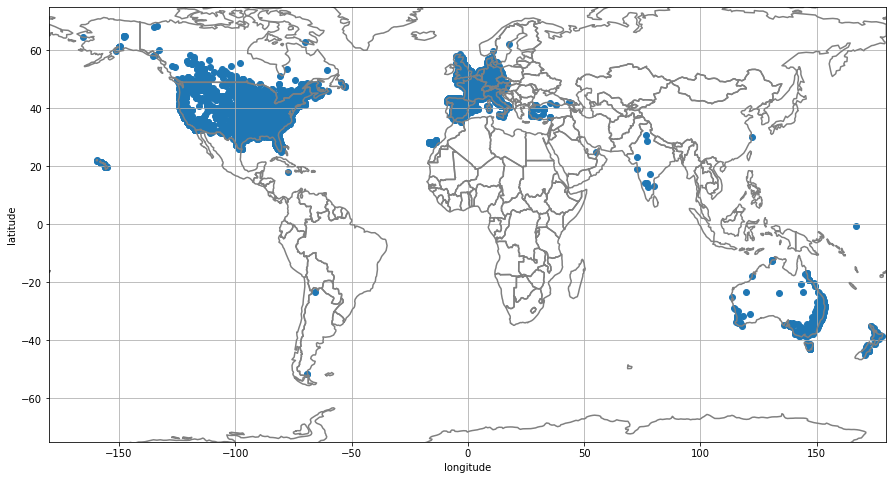

In [6]:
draw_earth(ylim=(-75, 75))
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.grid()
plt.scatter(GEO[::step, 0], GEO[::step, 1])
plt.show()

## 0.1. [1 point] Ok. Let's prepare ourselves to read the data from the hard drive

We will prepare id-based shards (data will be distributed into equal files with ranges `[0..capacity-1], [capacity..2*capacity-1], ...`. Each shard will store `capacity` elements. Your task is to complete the implementation with `iterate_dataset` function.

In [7]:
def split_shards(file, folder='shard', capacity=20000):
    import pickle, os, math, gc
    if not os.path.exists(folder):
        os.mkdir(folder)
    with open(file, "rb") as f:
        dataset = pickle.load(f)
    nshards = len(dataset) // capacity

    if nshards * capacity < len(dataset):
        nshards += 1
    
    for i in range(nshards):
        with open(f"{folder}/{i}", 'wb') as f:
            part = dataset[i * capacity:(i+1)*capacity]
            pickle.dump(part, f)
    dataset = None
    gc.collect()            

    
def dataset_get(indices, folder='shard', capacity=20000) -> list:
    result = []
    groups = {}
    for i in indices:
        x = i // capacity
        if x not in groups:
            groups[x] = []
        groups[x].append(i)
    for x in groups:
        with open(f"{folder}/{x}", "rb") as f:
            sha = pickle.load(f)
            for i in groups[x]:
                row = sha[i % capacity]
                result.append(row)
    return result


# Returns an iterator, which goes through all elements, consequently opening files
def iterate_dataset(items, folder="shard", capacity=20000):
    nshards = items // capacity
    if nshards * capacity < items:
        nshards += 1

    for shard_id in range(nshards):
        with open(f'./{folder}/{shard_id}', 'rb') as f:
            shard = pickle.load(f)
        for item in shard:
            yield item


In [8]:
split_shards("./poi_sample01.pickle")

asserts:

In [9]:
i = 0
for r in iterate_dataset(N):
    i += 1

assert i == N

asserts:

In [10]:
for i in [137, 40000, 600000]:
    assert np.allclose(GEO[i,:], dataset_get([i])[0][0], atol=5*1e-2), ""

In [11]:
dataset_get([1, 10, 1000234, N-1])

[([-58.4339539, -34.6028583],
  'CreationFlow, Professional, Computer Services. AR, Ciudad de Buenos Aires, Vera 15 3-B'),
 ([13.9706993103, 46.6813430786],
  'Bahnhof Ossiach-Bodensdorf. AT, Bodensdorf, '),
 ([-117.642377, 34.068324],
  'Industrial Labor Management, Professional, Management & Consulting. US, Ontario, 647 E E St'),
 ([28.0354352, -26.1470966],
  'ScoreGrid, Professional, Computer Services. ZA, Johannesburg, 158 Jan Smuts Avenue Rosebank')]

---

# And now the task!
Ok. We are ready to perform the following steps utilizing functions beyond:
1. Build **coordinate search index**. We will use it to obtain POI from the given region.
3. Implement **vector text embedding index** (Annoy, HNSW) to serve semantic queries.
3. Implement **geocoding** with cache. We will use it to obtain city coordinates.
4. Impement search for **double queries: town and location type**.

# 1. Create spacial index for points of interest

We will store dataset rows numbers as values, and coordinates as keys. Please use [KDtree](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html#sklearn.neighbors.KDTree) or [BallTree](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html#sklearn.neighbors.BallTree) from sklearn.

## 1.1. [5 points] Build the index and return it

Implement the following functions. To get the full grade:
- `build_geospacial_index` should build and return a search tree object: KDTree or BallTree.
- `kNN` accepts a 2D-point, `k` neighbours parameter, and returns **approximate** `k` neighbours (they can be different from the real neighbours).
- `inRadius` accepts a 2D-point, L<sub>2</sub> `radius`, and returns points inside the radius.

In [12]:
def build_geospacial_index(points, leaf_size=5) -> BallTree:
    return BallTree(points, leaf_size)


def kNN(query_point: list, k: int, index: BallTree) -> list:
    return list(index.query(np.array([query_point]), k)[1][0])


def inRadius(query_point: list, r: float, index: BallTree) -> list:
    return list(index.query_radius(np.array([query_point]), r)[0])

In [13]:
spaidx = build_geospacial_index(GEO)

In [14]:
test_id = 13

idx = kNN(GEO[test_id], 10, spaidx)
print(sorted(idx))
assert test_id in idx, "Point itself should be in results"

idx = inRadius(GEO[test_id], 0.0625, spaidx)
print(sorted(idx))
assert test_id in idx, "Point itself should be in results"

[13, 145, 351, 2178, 11968, 15497, 16505, 23285, 24681, 26327]
[13, 145, 351, 2178, 10783, 11968, 14229, 14999, 15497, 16282, 16505, 16642, 16702, 20423, 21021, 23285, 24681, 26327, 27584]


## 1.2. [4 points] Tricky assert

Some keys (coordinates) in the dataset (surprise!) are duplicates. Unfortunately search trees (in basic implemenation) cannot support duplicates. Thus you can follow one of the strategies:
- a key (coordinateS) corresponds to multiple values. This may require additional data strictures.
- improve the data (coordinates) to avoid collisions (e.g. lake sure they never coinside)

Pass the assert to get full points.

In [15]:
coords = [(1, 2), (1, 4), (1, 2)]
tree = BallTree(coords, leaf_size=2)

dsts, ids = tree.query(np.array([(1, 2)]), 3)

for i in range(len(ids[0])):
    print(f'Distance to neigbour #{ids[0][i]} = {dsts[0][i]}')

Distance to neigbour #0 = 0.0
Distance to neigbour #2 = 0.0
Distance to neigbour #1 = 2.0


### **Read this please**:

The coordinate at index 1966663 (i.e., `GEO[1966663]`) contains more than 1000 different POIs (i.e., distances to all its 10012 neighbors = 0, check the proof in the next cell), so the nearest 1000 happen to not include the original `query_point` (since results are sorted) **and that's why the assertion fails.**

For this type of assertion to work, k needs to be at least `len(x)` where `x` is the list of neighbors `n` that satisfy `dist(query_point, n) = 0`

In this example, increasing `k` from 1000 to 10012 will just do the job. 

In [16]:
for target_coord in [GEO[1966663], GEO[1480877], GEO[2126566]]:
    count = 1
    for coord, addr in iterate_dataset(N):
        coord = np.array(coord).astype(np.float16)
        if coord[0] == target_coord[0] and coord[1] == target_coord[1]:
            # print(f"POI #{count}: {addr}")
            count += 1

    print(f"Number of POIs at {target_coord} = {count}")

Number of POIs at [-74.    40.75] = 10012
Number of POIs at [-115.3    36.16] = 175
Number of POIs at [-118.4   34.2] = 395


In [17]:
points = [1966663, 1480877, 2126566]
for p in points:
    x = GEO[p, :]
    r = kNN(x, 20000, spaidx)
    assert (p in r), "Query did not return itself"

## 1.3. [Optional demo] How leaf size influences build and search speed?

Let us look at how parameter of leaf size affects speed of search and construction

100%|█████████████████████████████████████████████| 4/4 [00:13<00:00,  3.41s/it]


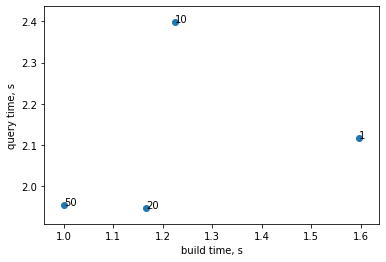

In [18]:
queries = random.sample(range(N), 1000)
leaf_sizes = [1, 10, 20, 50]

build_times = []
query_times = []
for ls in tqdm(leaf_sizes):
    start = time.time()
    idx = build_geospacial_index(GEO, ls)
    build_times.append(time.time() - start)
    
    start = time.time()
    for q in queries:
        d, r = spaidx.query([GEO[q]], 10000, sort_results=False, breadth_first=True)
    query_times.append(time.time() - start)
    idx = None
    gc.collect()

plt.xlabel("build time, s")
plt.ylabel("query time, s")
plt.scatter(build_times, query_times)
for i, ls in enumerate(leaf_sizes):
    plt.annotate(str(ls), (build_times[i], query_times[i]))

## 1.4. [5 points] Range queries?

Ok, you have a **radius query**, but what about **rectangual ranges**? Using the functions you already wrote, please, implement the range query given `north-east` and `south-west` corners. Pass the asserts to get points.

In [19]:
# Returns ids of the points in a rectangular range
def get_in_range(ne, sw, spacial_index, GEO) -> list:
    ne, sw = np.array(ne), np.array(sw)
    nex, ney = ne[0], ne[1]
    swx, swy = sw[0], sw[1]

    # center and radius of the circle circumscribing the rectangle
    center = [(swx + nex) / 2, (swy + ney) / 2]
    radius = np.linalg.norm(ne - sw)

    # get points in radius, excluding the ones outside the rectangle
    ids = inRadius(center, radius, spacial_index)
    result = []
    for idx in ids:
        coord = GEO[idx]
        if coord[0] < swx or coord[0] > nex or coord[1] < swy or coord[1] > ney:
            continue
        result.append(idx)

    return sorted(result)

In [20]:
def print_starbucks(ids):
    for row in dataset_get(ids):
        if 'Starbucks' in row[1]:
            print(row[1])

asserts:

In [21]:
ids = get_in_range([-73.97, 40.75], [-74.03, 40.70], spaidx, GEO)

assert any(map(
            lambda x: 'Manhattan, 80 Delancey St' in x[1], 
            dataset_get(ids))), "This Starbucks should be in place!"

print_starbucks(ids)

Starbucks, Restaurant, . US, New York, 325 W 49 St
Starbucks, Restaurant, . US, Manhattan, 195 Broadway
Starbucks, Restaurant, . US, Manhattan, 1585 Broadway
Starbucks Coffee, Coffee & Tea, . US, Hoboken, 51 Newark St
Starbucks Coffee, Coffee & Tea, . US, New York, 450 W 33rd St
Starbucks Coffee, Coffee & Tea, . US, New York, 151 W 34th St
Starbucks Coffee, Coffee & Tea, . US, New York, 55 Liberty St
Starbucks Coffee, Coffee & Tea, . US, New York, 4 W 21st St
Starbucks Coffee, Coffee & Tea, . US, New York, 378 Avenue of The Americas
Starbucks Coffee, Coffee & Tea, . US, New York, 150 Varick St
Starbucks Coffee, Coffee & Tea, . US, New York, 1372 Broadway
Starbucks Coffee, Coffee & Tea, . US, New York, 1530 Broadway
Starbucks, Coffee & Tea, . US, Manhattan, 80 Delancey St
Starbucks, Coffee & Tea, . US, Manhattan, 471 Broadway
Starbucks, Coffee & Tea, . US, Manhattan, 280 Park Ave
Starbucks, Coffee & Tea, . US, New York, 787 7th Ave
Starbucks, Coffee & Tea, . US, Manhattan, Hilton New Yo

# 2. Geocoding

In this block we will learn, how to convert text place names into coordinate rectangles.

## 2.1. [5 points] Implement geocoding
which returns north-eastern and south-western points of the place. Pass asserts.

In [22]:
# Returns a pair of tuples: NE and SW corners.
def get_town_range_coordinates(town: str) -> tuple:
    box = json.loads(
        requests.get(f'https://nominatim.openstreetmap.org/search/{town}?format=json&limit=1').content
    )[0]["boundingbox"]

    NE, SW = ((float(box[3]), float(box[1])), (float(box[2]), float(box[0]))) 
    return NE, SW

asserts:

In [23]:
p = get_town_range_coordinates('Pittsburgh downtown')
print(p)
assert p[1][0] <= -80. <= p[0][0] and p[1][1] <= 40.44 <= p[0][1] 

((-79.9849874, 40.4470976), (-80.0132624, 40.433983))


## 2.2. [5 points] Town queries

Now, having a range query and geocoding, we can implement town-queries!

In [24]:
# Returns dataset indices of all POIs in a given town
def get_in_town(town, index, GEO) -> list:
    NE, SW = get_town_range_coordinates(town)
    return get_in_range(NE, SW, index, GEO)

In [25]:
ids = get_in_town('Pittsburgh downtown', spaidx, GEO)

assert any(map(
            lambda x: 'US, Pittsburgh, 810 River Ave' in x[1], 
            dataset_get(ids))), "This Starbucks should be in place!"

print_starbucks(ids)

Starbucks Coffee, Coffee & Tea, . US, Pittsburgh, 810 River Ave
Starbucks Coffee, Utilities, Mobile Phone. US, Pittsburgh, 1719 Penn Ave


## 2.3. [M][5 points] Caching

Why should you pay for every geocaching request, if you can cache them? Implement a cached version on geocoding. The second query does not use internet.

In [26]:
GEO_CACHE = {}

def get_town_range_coordinates_cached(town: str) -> tuple:
    global GEO_CACHE
    if town not in GEO_CACHE:
        GEO_CACHE[town] = get_town_range_coordinates(town)
    return GEO_CACHE[town]

def get_in_town_cached(town: str, index, GEO) -> list:
    NE, SW = get_town_range_coordinates_cached(town)
    return get_in_range(NE, SW, index, GEO)

In [27]:
ids = get_in_town_cached('Boulder, CO', spaidx, GEO)
print_starbucks(ids)
ids = get_in_town_cached('Boulder, CO', spaidx, GEO)
print_starbucks(ids)

Starbucks Coffee, Coffee & Tea, . US, Boulder, 1427 Pearl St
Starbucks Coffee, Coffee & Tea, . US, Boulder, 2770 Pearl St
Starbucks Coffee, Coffee & Tea, . US, Boulder, 1427 Pearl St
Starbucks Coffee, Coffee & Tea, . US, Boulder, 2770 Pearl St


# 3. Text search

We are done with geography, but we have no clear method to search for categories. What if we prepare vector index of location names?

In [28]:
nlp = en_core_web_md.load()

names = {}

## 3.1. [5 points] Embedding

Here is the trick. If you use any embedding model "as it is", it may take some hours to prepare 2M embeddings. It's ok if you can wait for **3 points**, but...

To get full points, please think, how you can speed up the process with embedding to less than 5 minutes?

HINT: spacy model `nlp` has a [dictionary for word embeddings](https://spacy.io/api/vocab). You can access `nlp.vocab[word].vector` to get word embedding, `nlp.vocab.strings` map stores integer indices.

In [29]:
WORDS = set([a.strip().lower() for a in open('./words.txt', 'r').readlines()])

# Mark the names that are common and stored in nlp.vocab
for word in WORDS:
    if nlp.vocab.has_vector(word):
        names[word] = True
        
# I added my own assertions :)
assert 'hospital' in names
assert 'pharmacy' in names
assert 'restaurant' in names
assert 'hotel' in names

In [30]:
# Returns a vector (300, ) of normalized text embedding
# Uses the cached word embedding dictionary to make embedding fast
# unless the text is a common word, in this case we compute embedding for it.

def embed(text, nlp):
    result = None
    text = text.lower()
    for word in word_tokenize(text):
        if word in names:
            if result is None:
                result = np.zeros((300))
            result += nlp.vocab[word].vector
    
    if result is None:
        if text in names:
            v = nlp(text).vector
            return v / np.linalg.norm(v)
        else:
            return None
    
    return result / np.linalg.norm(result)

In [32]:
embeddings = np.zeros((N, 300), dtype=np.float16)

for i, item in enumerate(tqdm(iterate_dataset(N), total=N)):
    name = item[1].split('.')[0]
    emb = embed(name, nlp)
    if emb is not None:
        embeddings[i, :] = emb

100%|███████████████████████████████| 2173512/2173512 [04:45<00:00, 7603.70it/s]


**It took less than 5 minutes :)**

## 3.2. [10 points] Vector index

Here we will build vector index for our embeddings. I want to warn Windows users, that they can observe problems with installing Faiss and HNSWlib. Still this is not the reason not to try :)
Choose **one of the libraries** and fulfill the requirements:
1. If you choose [FAISS](https://faiss.ai/). Get started with [installation](https://faiss.ai/#install) and this [tutorial](https://github.com/facebookresearch/faiss/wiki/Getting-started). To get full points your index must use [Product Quantization](https://github.com/facebookresearch/faiss/wiki/Lower-memory-footprint): 50 subvectors, 8 bits (1 byte) each. Use custom `nprobe` parameter equal to 23. Number or Voronoi cells is `65536`. Refer to [this document](https://github.com/facebookresearch/faiss/wiki/Guidelines-to-choose-an-index#if-1m---10m-ivf65536_hnsw32) to understand recommendations.
2. If you use [HNSWlib](https://github.com/nmslib/hnswlib) (or [nmslib](https://github.com/nmslib/nmslib)) then follow these requirements. Use `cosine` metric for index construction, maximum number of outgoing connections (max outdegree) in the graph is 16, `ef` parameter at construction time should be `250`. Some useful information is given [here](https://github.com/nmslib/nmslib/blob/master/manual/methods.md).
3. For [Annoy](https://github.com/spotify/annoy) you should cosine distance for the space (if vectors are normed, you can use dot product intead), use all CPU cores at construction time. Build the index on right on disk, then load. Your index should consist of 37 trees.

**NB** If you run on not-very-modern hardware (e.g. your RAM is less then 8GB), then you'd better reduce dataset size (e.g. take a specific region only like US east cost). You can also reduce other parameters only for the sake of RAM efficiency, but please specify and justify your decisions.

e.g.
```    
roi = set(get_in_range([-68.645945, 43.163175], [-80.461502, 37.097044], spaidx, GEO))
```


**HINT** You can remove `embeddings` array and call `gc.collect()` before loading index to RAM.

**HINT2** Should you index vectors with $[0]^N$ values?

In [33]:
# Builds annoy index on disk (filename='index.ann')
def build_vector_index():
    global embeddings
    index = AnnoyIndex(300, 'dot')
    index.on_disk_build('index.ann')
    
    for i, emb in enumerate(tqdm(embeddings)):
        index.add_item(i, emb)
    
    # Remove embeddings to free memory
    embeddings = None
    gc.collect()
    
    index.build(37, n_jobs=7)

# Loads the index from disk (builds first if the index doesn't exist)
def get_vector_index():
    if not os.path.exists('index.ann'):
        build_vector_index()
    index = AnnoyIndex(300, 'dot')
    index.load('index.ann')
    return index

# Query the Approximate K-Nearest Neighbours using the built index
def get_kNN_embeddings(embedding, k, index):
    return index.get_nns_by_vector(embedding, k)

In [34]:
embedding_index = get_vector_index()

100%|██████████████████████████████| 2173512/2173512 [00:55<00:00, 39121.31it/s]


In [35]:
result = get_kNN_embeddings(embed('pharmacy', nlp), 1000, embedding_index)
assert len(result) == 1000

# 4. [5 points] And now we want to have this together!

Say no more:

In [36]:
# Returns a list of data items (queries in town), with coordinates and texts   
def find(town, query) -> list:
    query_locations = set(get_kNN_embeddings(embed(query, nlp), 1000, embedding_index))
    POIs_in_town = set(get_in_town(town, spaidx, GEO))

    return dataset_get(POIs_in_town.intersection(query_locations))

In [37]:
# Note: I changed "Manhattan downtown" to just "Manhattan"
# Because the free Geocoding API I use is not as smart as Google's

items = find('Manhattan', 'hospital')
print(items[:20])
xy = np.array([row[0] for row in items])

[([-73.9793, 40.689401], 'The Brooklyn Hospital Center, Health Services, Hospital. US, Brooklyn, 19 Rockwell Place'), ([-73.994301, 40.752499], 'The Jewish Home & Hospital Lifecare, Health Services, Hospital. US, New York, 330 W 34th St'), ([-73.912052, 40.843475], 'Bronx Lebonon Hospital, Health Services, Hospital. US, Bronx, 1645 Grand Concourse'), ([-73.976501, 40.739498], 'Bellevue Hospital, Health Services, Hospital. US, New York, 462 1st Ave'), ([-73.991589, 40.757525], 'Hospital League Local 1199, Health Services, Hospital. US, New York, 330 W 42nd St'), ([-73.977642, 40.689811], 'The Brooklyn Hospital Center, Health Services, Hospital. US, Brooklyn, 121 Dekalb Ave'), ([-73.987801, 40.7701], "St Luke's Roosevelt Hospital, Health Services, Hospital. US, New York, 1000 10th Ave"), ([-73.991402, 40.694], 'Brooklyn University Hospital & Medical Center, Health Services, Hospital. US, Brooklyn, Linden Blvd At Brk'), ([-73.961403, 40.7743], 'Lenox Hill Hospital, Health Services, Hospit

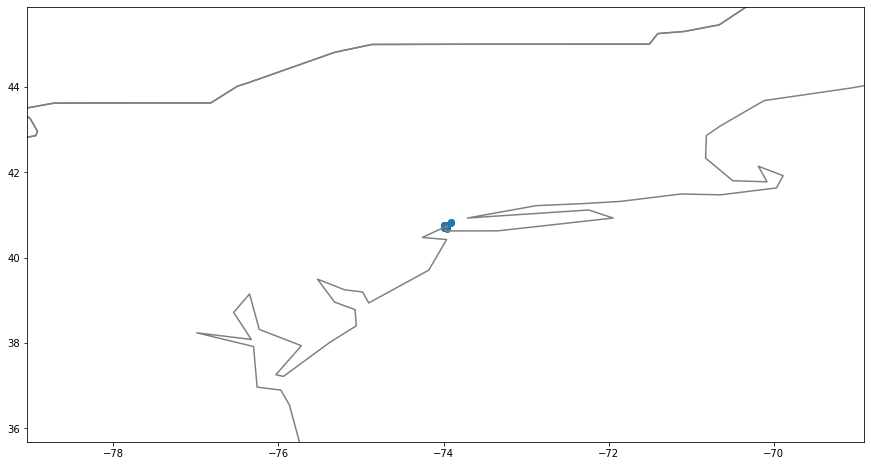

In [38]:
NE, SW = get_town_range_coordinates_cached('Manhattan')
draw_earth(xlim=(SW[0] - 5, NE[0] + 5), ylim=(SW[1] - 5, NE[1] + 5))
plt.scatter(xy[:, 0], xy[:, 1])
plt.show()

# 5. [M] Master level

You know, that you can implement an arbitrary metric? To get full points your task will be the following:

1. Choose a small sample of the original data (e.g. 10K New York points).
2. Describe each point with coordinate vector and discrete set of words in the name. **Design the metric function** -- a function, which accepts 2 objects and returns a number. This function should esimate "distance" in a merged space of words and distances. No common words? Far. Both common words and vectors are similar? Close!
3. **Use this metric in index data structure**. Maybe you will [extend nmslib](https://github.com/nmslib/nmslib/issues/478), maybe you will prefer my [NSW implementation](https://github.com/IUCVLab/proximity-cut/blob/master/modules/nsw/nsw.py) ([usage](https://github.com/IUCVLab/proximity-cut/blob/master/tests/nsw-visualization.ipynb), [custom HVDM metric](https://github.com/IUCVLab/proximity-cut/blob/master/modules/tools/hvdm.py), custom metric application -- pass `dist=func` into constructor). Or maybe you will find a data structure which supports this from the box :)
4. Run some tests!

## 5.1. Sample some data

In [133]:
# 50K POIs in NYC
NYC = dataset_get(get_in_town_cached('new york', spaidx, GEO))[:50000]

# Create embeddings from the POI addresses.
# The first two dimensions are the POI coordinates (list)
embeddings = np.zeros((50000, 302))

for i, item in enumerate(tqdm(NYC)):
    emb = embed(item[1].split('.')[0], nlp)
    if emb is not None:
        embeddings[i, :] = [*item[0], *emb]

100%|███████████████████████████████████| 50000/50000 [00:07<00:00, 6464.60it/s]


## 5.2. [M][10 points] Metric which accepts 2 dataset items and returns metric

In [134]:
# The metric combines euclidean distance for positions
# and cosine similarity for name embedding.

# a, b are vectors (302, )
# the first 2 dimensions: POI location
# the rest 300 dimension: POI name embedding

class CustomDistance:
    def distance(self, a, b):
        eucl_dist = np.linalg.norm(a[:2] - b[:2])
        cos_sim = np.dot(a[2:], b[2:]) # no need to divide as vectors are normalized
        return eucl_dist * cos_sim 

## 5.3. [M][25 points] Build an index

In [135]:
from nearpy import Engine
from nearpy.hashes import RandomBinaryProjections
from nearpy.filters import NearestFilter

def build_index():
    engine = Engine(302,
                    vector_filters=[NearestFilter(20)],
                    lshashes=[RandomBinaryProjections('default', 1000)],
                    distance=CustomDistance()
                   )
    
    for i, vec in enumerate(tqdm(embeddings)):
        engine.store_vector(vec, i)
    return engine

custom_idx = build_index()

100%|███████████████████████████████████| 50000/50000 [00:36<00:00, 1365.52it/s]


## 5.4. [M][10 points] write and pass some test

In [136]:
def find(town, query, index):
    NE, SW = get_town_range_coordinates_cached(town)
    town_coords = [(SW[0] + NE[0]) / 2, (SW[1] + NE[1]) / 2] 
    emb = embed(query, nlp)
    query_locations = [ i for _, i, _ in index.neighbours(np.array([*town_coords, *emb])) ]
    return [NYC[q] for q in query_locations]

In [138]:
find("Manhattan", "coffee", custom_idx)

[([-73.957841, 40.731428],
  'Brooklyn Label, Coffee & Tea, . US, Brooklyn, 180 Franklin St'),
 ([-73.981759, 40.746383],
  'Lavazza Premium Coffee, Coffee & Tea, . US, New York, 3 Park Avenue')]